In [1]:
import random
import os
import re
import json
import numpy as np
import pandas as pd
import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import lightgbm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec
# from PIL import Image
# # from PIL import ImageFile
# # ImageFile.LOAD_TRUNCATED_IMAGES = True
# from transformers import ViltProcessor, ViltModel


random_seed = 2020
random.seed(random_seed)
np.random.seed(random_seed)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_data = pd.read_csv('../data/feature_data_530.csv')
# glove
glove_tags = pd.read_csv('../data/alltags_feature.csv')
glove_title = pd.read_csv('../data/title_feature.csv')
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)
train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]

train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

In [3]:
X_train = train_feature_df[:int(-0.1*len(train_feature_df))]
Y_train = train_label_df['label'][:int(-0.1*len(train_feature_df))]
X_test = train_feature_df[int(-0.1*len(train_feature_df)):]
Y_test = train_label_df['label'][int(-0.1*len(train_feature_df)):]

In [7]:
train_label_df['label'].loc[100]

10.4

In [8]:
pd.DataFrame(Y_train)

,label
0,11.18
1,15.15
2,10.99
3,8.63
4,11.16
...,...
275047,6.75
275048,8.05
275049,11.07
275050,8.13


In [14]:
train_feature_df

,Uid,Uid_count,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,img_length,...,title_fe_290,title_fe_291,title_fe_292,title_fe_293,title_fe_294,title_fe_295,title_fe_296,title_fe_297,title_fe_298,title_fe_299
0,21894,4,5,65,75,33,6,128,12,333,...,-0.055784,0.197610,-0.166620,-0.007064,0.308736,0.138135,0.149598,0.184107,-0.049617,0.011684
1,53866,13,0,75,139,56,13,800,65,500,...,0.296695,0.087271,0.126468,-0.103056,0.147320,0.193802,0.035001,-0.045986,0.080715,0.078193
2,26948,1,3,42,480,12,2,188,23,500,...,0.168270,0.003270,0.171345,0.108478,0.349160,-0.396890,-0.205695,0.068778,-0.128545,-0.080683
3,355,1,10,68,225,18,3,61,9,500,...,0.109710,0.117009,0.245160,-0.306995,0.387836,0.111045,0.157754,-0.086720,0.220020,-0.045470
4,315,31,2,43,317,8,1,146,19,500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,8689,7,4,7,194,9,1,262,35,500,...,-0.705970,-0.740560,0.477140,-0.055602,0.229310,-0.219060,0.244150,-0.113470,-0.038659,0.636760
305609,7509,1,6,48,282,4,1,65,9,500,...,0.277580,0.646810,-0.621820,0.342440,0.065437,-0.115160,-0.183480,-0.376420,-0.089649,-0.296500
305610,52220,3,0,60,390,12,1,83,8,500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305611,20298,112,7,55,527,7,3,146,19,500,...,-0.076936,-0.454270,-0.037311,0.468153,-0.178730,-0.034247,0.136299,0.051963,0.343003,-0.322013


In [41]:
# import numpy
# all_data = pd.read_csv('../data/feature_data_530.csv')
# # glove
# glove_tags = pd.read_csv('../data/alltags_feature.csv')
# glove_title = pd.read_csv('../data/title_feature.csv')
# all_data = pd.concat([glove_tags, glove_title, all_data], axis=1)
# train_all_data = all_data[all_data['train_type'] != -1]

# index = list(range(len(train_all_data)))
# length = len(train_all_data)
# len_valid = int(length * 0.15 + 0.6)
# train_data_df = train_all_data.loc[index[:-len_valid]]
# valid_data_df = train_all_data.loc[index[-len_valid:]]
# submit_all_data = all_data[all_data['train_type'] == -1]

# train_data_df = train_data_df.reset_index(drop=True)
# valid_data_df = valid_data_df.reset_index(drop=True)
# submit_all_data = submit_all_data.reset_index(drop=True)

# feature_columns = ['Pid', 'train_type', 'mean_label'] 
# feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
# feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

# train_feature_df = train_data_df.drop(feature_columns, axis=1)
# valid_feature_df = valid_data_df.drop(feature_columns, axis=1)

# submit_label_df = submit_all_data[['Pid', 'label']]
# submit_feature_df = submit_all_data.drop(feature_columns, axis=1)
# tfdf = train_feature_df.to_numpy(dtype='float')
# vfdf = valid_feature_df.to_numpy(dtype='float')
# sfdf = submit_feature_df.to_numpy(dtype='float')
# numpy.savetxt("../data/SMP.data.train", tfdf)
# numpy.savetxt("../data/SMP.data.val", vfdf)
# numpy.savetxt("../data/SMP.data.test", sfdf)

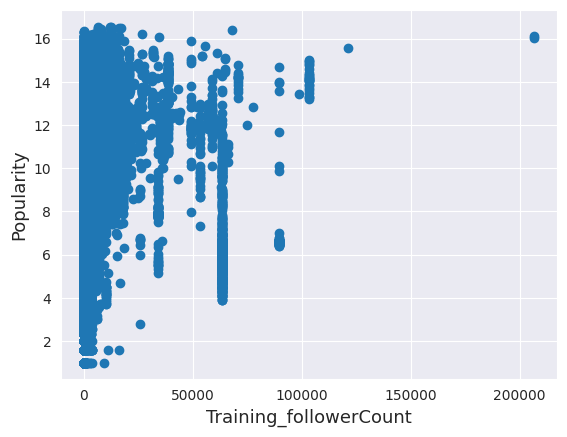

In [17]:
import math
fig, ax = plt.subplots()
# log_10_followerCount = [math.log(x+1) for x in train_all_data['followerCount']]

ax.scatter(x = train_all_data['followerCount'], y = train_all_data['label'])
plt.ylabel('Popularity', fontsize=13)
plt.xlabel('Training_followerCount', fontsize=13)
plt.show()

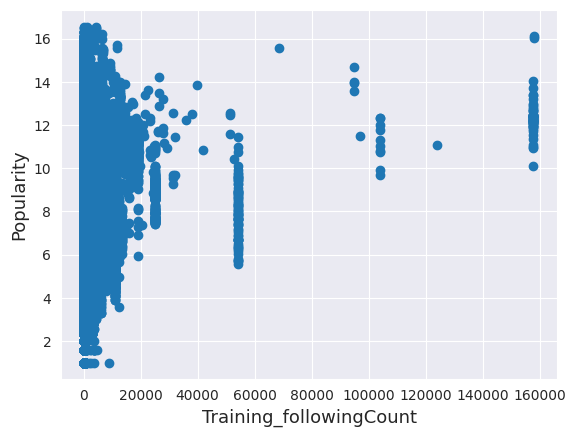

In [18]:
import math
fig, ax = plt.subplots()
# log_10_followingCount = [math.log(x+1) for x in train_all_data['followingCount']]

ax.scatter(x = train_all_data['followingCount'], y = train_all_data['label'])
plt.ylabel('Popularity', fontsize=13)
plt.xlabel('Training_followingCount', fontsize=13)
plt.show()

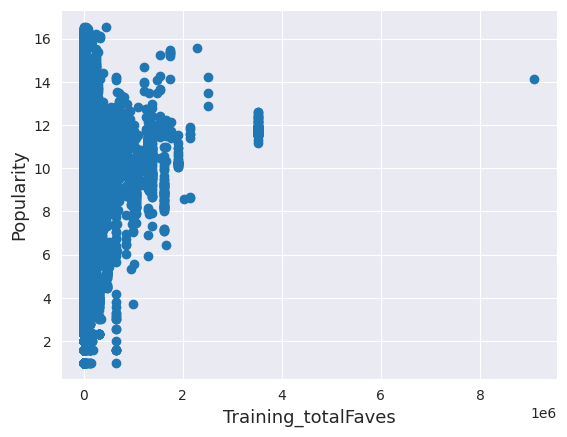

In [19]:
import math
fig, ax = plt.subplots()
# log_10_totalFaves = [math.log(x+1) for x in train_all_data['totalFaves']]

ax.scatter(x = train_all_data['totalFaves'], y = train_all_data['label'])
plt.ylabel('Popularity', fontsize=13)
plt.xlabel('Training_totalFaves', fontsize=13)
plt.show()


 mu = 3.13 and sigma = 3.55



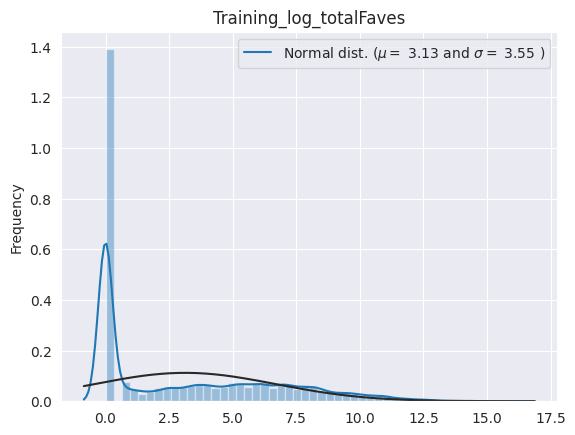

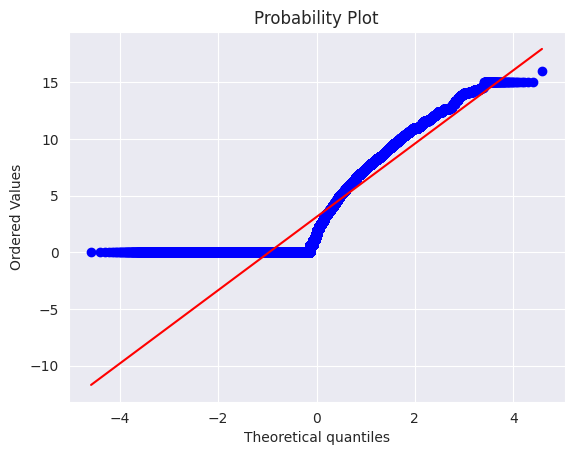

In [20]:
log_totalfaves = [math.log(x+1) for x in train_all_data['totalFaves']]
sns.distplot(log_totalfaves , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_totalfaves)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Training_log_totalFaves')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_totalfaves, plot=plt)
plt.show()


 mu = 3.04 and sigma = 3.58



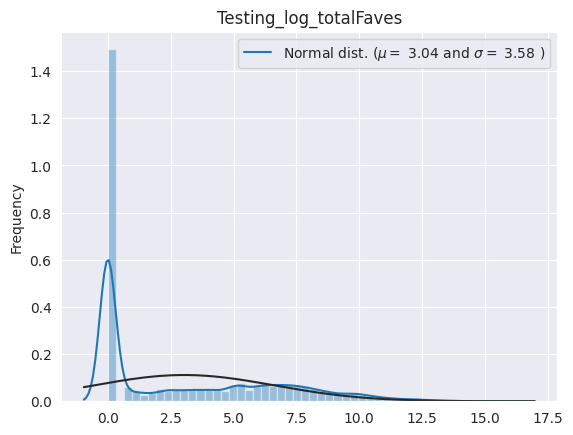

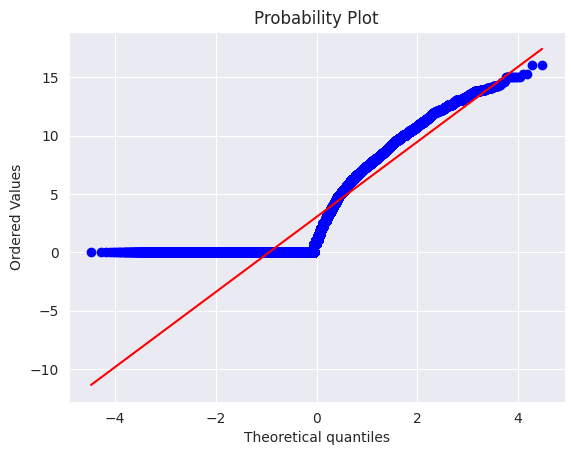

In [21]:
log_tstotalfaves = [math.log(x+1) for x in submit_all_data['totalFaves']]
sns.distplot(log_tstotalfaves , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_tstotalfaves)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Testing_log_totalFaves')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_tstotalfaves, plot=plt)
plt.show()

In [38]:
print("Skewness of Training_totalFaves: %f" % train_all_data['totalFaves'].skew())
print("Kurtosis of Training_totalFaves: %f" % train_all_data['totalFaves'].kurt())
print("Skewness of Training_log_totalFaves: %f" % pd.DataFrame(log_totalfaves).skew())
print("Kurtosis of Training_log_totalFaves: %f" % pd.DataFrame(log_totalfaves).kurt())
print("Skewness of Testing_totalFaves: %f" % submit_all_data['totalFaves'].skew())
print("Kurtosis of Testing_totalFaves: %f" % submit_all_data['totalFaves'].kurt())
print("Skewness of Training_log_totalFaves: %f" % pd.DataFrame(log_tstotalfaves).skew())
print("Kurtosis of Training_log_totalFaves: %f" % pd.DataFrame(log_tstotalfaves).kurt())

Skewness of Training_totalFaves: 29.018484
Kurtosis of Training_totalFaves: 1198.004150
Skewness of Training_log_totalFaves: 0.769032
Kurtosis of Training_log_totalFaves: -0.619373
Skewness of Testing_totalFaves: 48.760805
Kurtosis of Testing_totalFaves: 4676.440405
Skewness of Training_log_totalFaves: 0.787328
Kurtosis of Training_log_totalFaves: -0.672356



 mu = 3.29 and sigma = 2.91



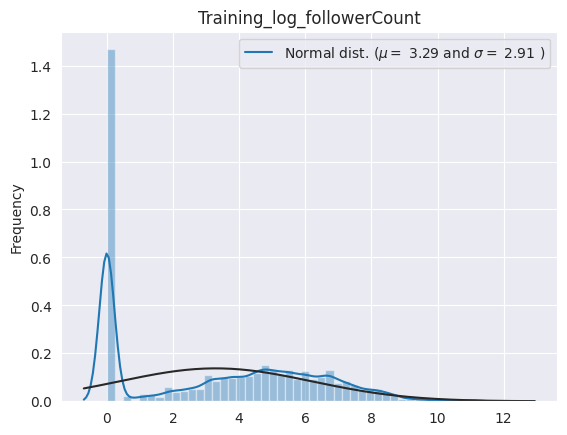

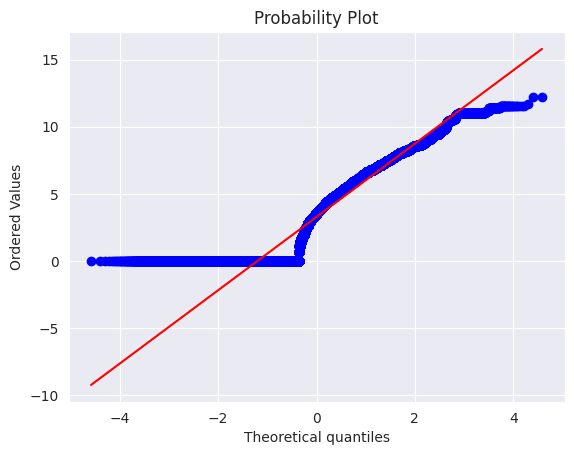

In [22]:
log_followerCount = [math.log(x+1) for x in train_all_data['followerCount']]
sns.distplot(log_followerCount , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_followerCount)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Training_log_followerCount')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_followerCount, plot=plt)
plt.show()


 mu = 3.21 and sigma = 2.96



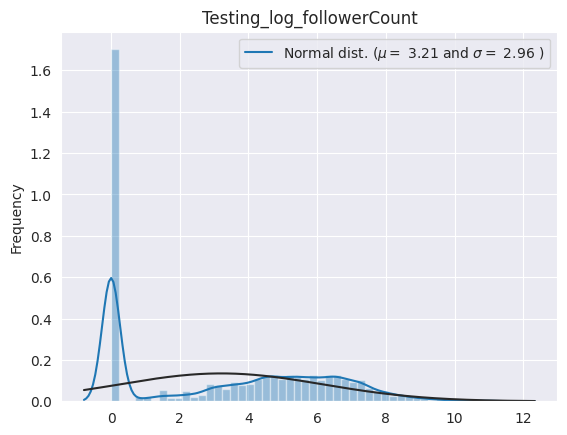

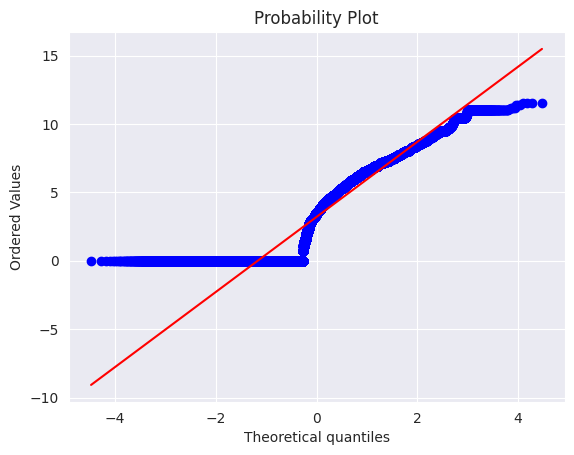

In [23]:
log_tsfollowerCount = [math.log(x+1) for x in submit_all_data['followerCount']]
sns.distplot(log_tsfollowerCount , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_tsfollowerCount)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Testing_log_followerCount')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_tsfollowerCount, plot=plt)
plt.show()

In [36]:
print("Skewness of Training_followerCount: %f" % train_all_data['followerCount'].skew())
print("Kurtosis of Training_followerCount: %f" % train_all_data['followerCount'].kurt())
print("Skewness of Training_log_followerCount: %f" % pd.DataFrame(log_followerCount).skew())
print("Kurtosis of Training_log_followerCount: %f" % pd.DataFrame(log_followerCount).kurt())
print("Skewness of Testing_followerCount: %f" % submit_all_data['followerCount'].skew())
print("Kurtosis of Testing_followerCount: %f" % submit_all_data['followerCount'].kurt())
print("Skewness of Training_log_followerCount: %f" % pd.DataFrame(log_tsfollowerCount).skew())
print("Kurtosis of Training_log_followerCount: %f" % pd.DataFrame(log_tsfollowerCount).kurt())

Skewness of Training_followerCount: 15.063711
Kurtosis of Training_followerCount: 298.209987
Skewness of Training_log_followerCount: 0.193859
Kurtosis of Training_log_followerCount: -1.252728
Skewness of Testing_followerCount: 14.789079
Kurtosis of Testing_followerCount: 274.242387
Skewness of Training_log_followerCount: 0.207890
Kurtosis of Training_log_followerCount: -1.364836



 mu = 3.53 and sigma = 2.97



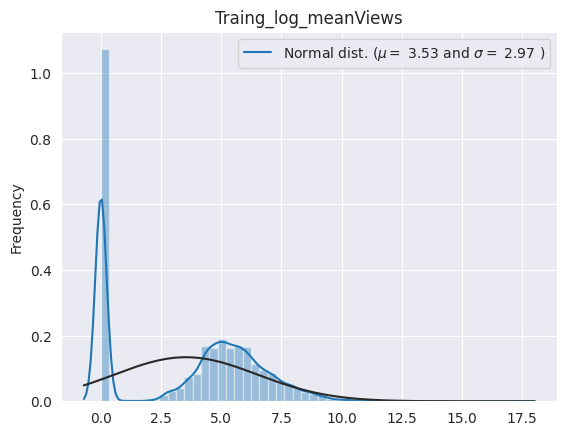

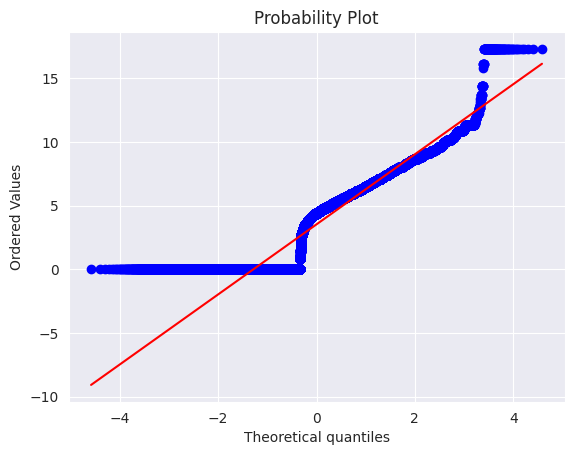

In [24]:
log_meanViews = [math.log(x+1) for x in train_all_data['meanView']]
sns.distplot(log_meanViews , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_meanViews)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Traing_log_meanViews')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_meanViews, plot=plt)
plt.show()


 mu = 3.34 and sigma = 2.98



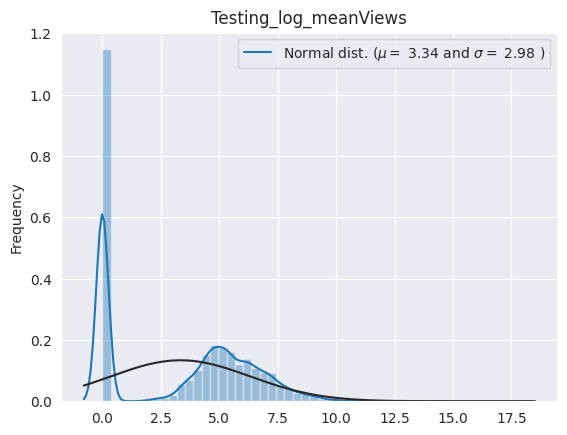

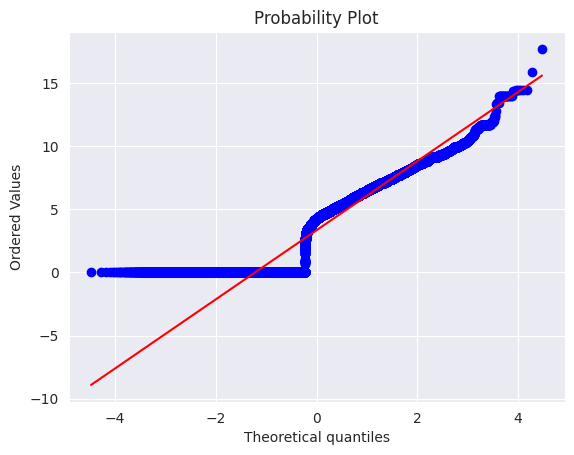

In [25]:
log_tsmeanViews = [math.log(x+1) for x in submit_all_data['meanView']]
sns.distplot(log_tsmeanViews , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_tsmeanViews)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Testing_log_meanViews')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_tsmeanViews, plot=plt)
plt.show()

In [54]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
aa = boxcox1p(submit_all_data['meanView'], boxcox_normmax(submit_all_data['meanView'] + 1))
aa

0          0.000000
1         16.364528
2         16.364528
3         12.228421
4         12.228421
            ...    
180576    10.601033
180577     0.000000
180578    12.205623
180579    13.332469
180580    11.222072
Name: meanView, Length: 180581, dtype: float64


 mu = 5.04 and sigma = 4.85



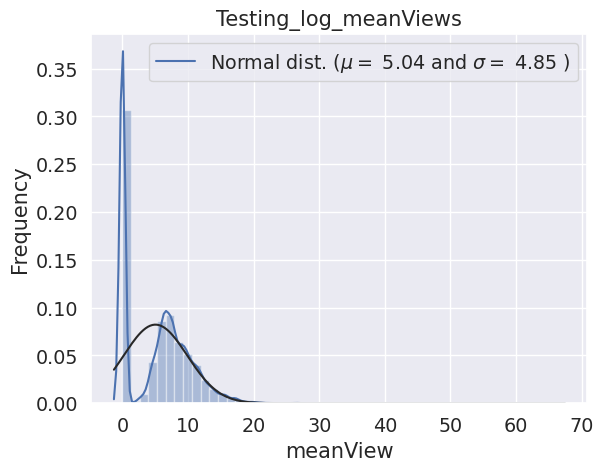

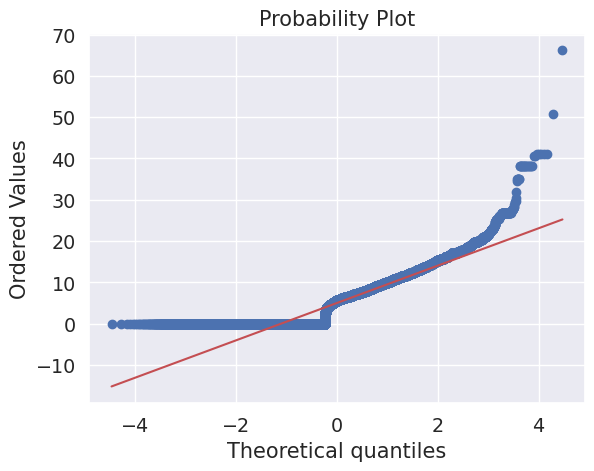

In [55]:
# log_tsmeanViews = [math.log(x+1) for x in submit_all_data['meanView']]

sns.distplot(aa , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(aa)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Testing_log_meanViews')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(aa, plot=plt)
plt.show()

In [35]:
#skewness and kurtosis
print("Skewness of Training_meanViews: %f" % train_all_data['meanView'].skew())
print("Kurtosis of Training_meanViews: %f" % train_all_data['meanView'].kurt())
print("Skewness of Training_log_meanViews: %f" % pd.DataFrame(log_meanViews).skew())
print("Kurtosis of Training_log_meanViews: %f" % pd.DataFrame(log_meanViews).kurt())
print("Skewness of Testing_meanViews: %f" % submit_all_data['meanView'].skew())
print("Kurtosis of Testing_meanViews: %f" % submit_all_data['meanView'].kurt())
print("Skewness of Training_log_meanViews: %f" % pd.DataFrame(log_tsmeanViews).skew())
print("Kurtosis of Training_log_meanViews: %f" % pd.DataFrame(log_tsmeanViews).kurt())

Skewness of Training_meanViews: 54.544304
Kurtosis of Training_meanViews: 2983.190939
Skewness of Training_log_meanViews: 0.003097
Kurtosis of Training_log_meanViews: -1.218210
Skewness of Testing_meanViews: 399.177419
Kurtosis of Testing_meanViews: 165260.949830
Skewness of Training_log_meanViews: 0.061483
Kurtosis of Training_log_meanViews: -1.424059



 mu = 6.41 and sigma = 2.47



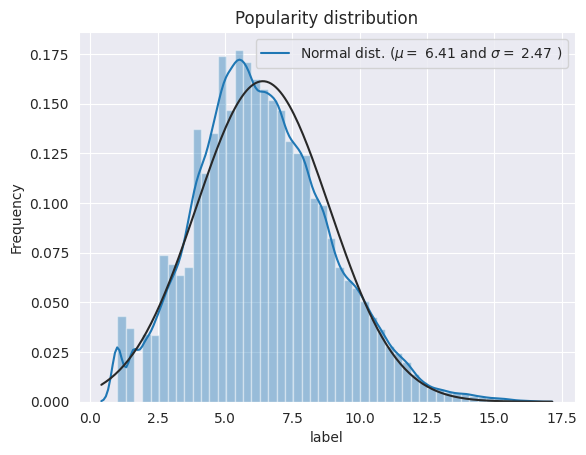

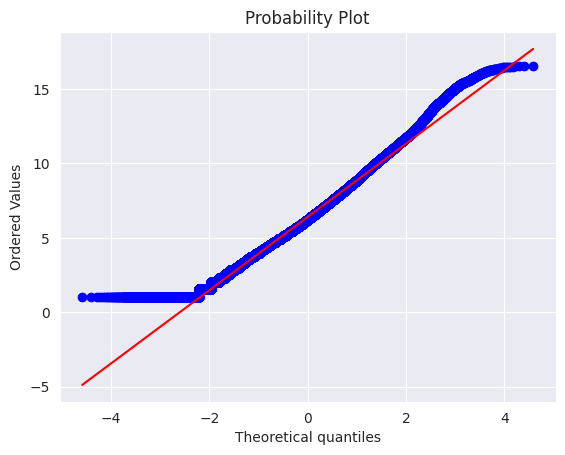

In [26]:
sns.distplot(train_all_data['label'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_all_data['label'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Popularity distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_all_data['label'], plot=plt)
plt.show()

In [32]:
#skewness and kurtosis
print("Skewness of Popularity: %f" % train_all_data['label'].skew())
print("Kurtosis of Popularity: %f" % train_all_data['label'].kurt())

Skewness of Popularity: 0.359054
Kurtosis of Popularity: 0.146188


In [30]:
norm_train_label = train_all_data['label'] - 1.29
norm_train_label = [x if x > 1.0 else 1.0 for x in norm_train_label]
norm_train_label[305609]

1.0


 mu = 5.14 and sigma = 2.42



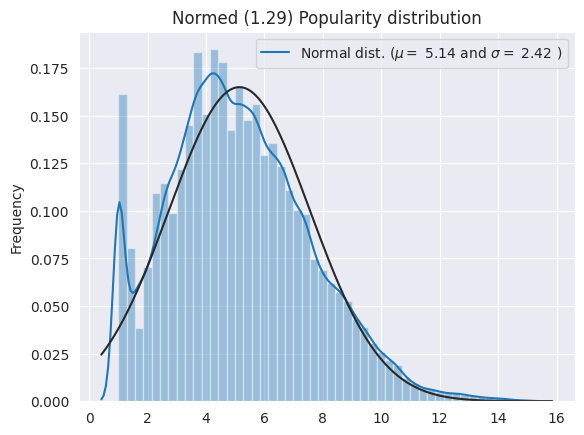

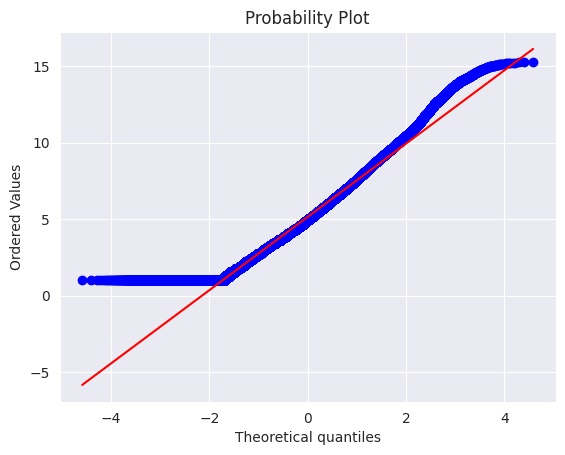

In [31]:
sns.distplot(norm_train_label , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(norm_train_label)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Normed (1.29) Popularity distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(norm_train_label, plot=plt)
plt.show()

In [34]:
#skewness and kurtosis
print("Skewness of Normed 1.29 Popularity: %f" % pd.DataFrame(norm_train_label).skew())
print("Kurtosis of Normed 1.29 Popularity: %f" % pd.DataFrame(norm_train_label).kurt())

Skewness of Normed 1.29 Popularity: 0.478606
Kurtosis of Normed 1.29 Popularity: 0.078134


In [3]:
columns = ['Category', 'Uid', 'Subcategory','Mediatype', 'Longitude', 'Geoaccuracy', 'Latitude', 
         'Title_len', 'Title_number','Alltags_len','Alltags_number', 'hour', 'day','weekday','week_hour',
          'year_weekday','photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
          'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
          'followingCount']
all_data[columns]

,Category,Uid,Subcategory,Mediatype,Longitude,Geoaccuracy,Latitude,Title_len,Title_number,Alltags_len,...,totalTags,totalGeotagged,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount
0,5,21894,65,1,0.00000,0,0.000000,33,6,128,...,2215,0,904,176,1446,4299.470263,1.531812,0.625173,2405,2729
1,0,53866,75,1,0.00000,0,0.000000,56,13,800,...,3991,542,6200,679,75883,735.884072,0.052594,0.081705,8491,236
2,3,26948,42,1,0.00000,0,0.000000,12,2,188,...,2930,1,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346
3,10,355,68,1,0.00000,0,0.000000,18,3,61,...,5707,716,76088,385,124017,148.035342,0.046018,0.613529,1233,1115
4,2,315,43,1,0.00000,0,0.000000,8,1,146,...,5344,12,0,102,9218,5300.882729,0.579735,0.000000,5781,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,0,46088,35,1,0.00000,0,0.000000,6,1,78,...,987,40,4341,84,347,833.933718,2.844380,12.510086,489,612
486190,0,12280,60,1,0.00000,0,0.000000,25,4,164,...,0,0,0,0,0,0.000000,0.000000,0.000000,0,0
486191,4,43496,28,1,4.88361,15,52.377734,41,7,85,...,21861,6422,5225,98,6556,1611.040268,3.334503,0.796980,702,113
486192,7,5492,27,1,0.00000,0,0.000000,15,3,305,...,5677,741,24679,373,2138,2480.537418,2.655285,11.543031,1092,389


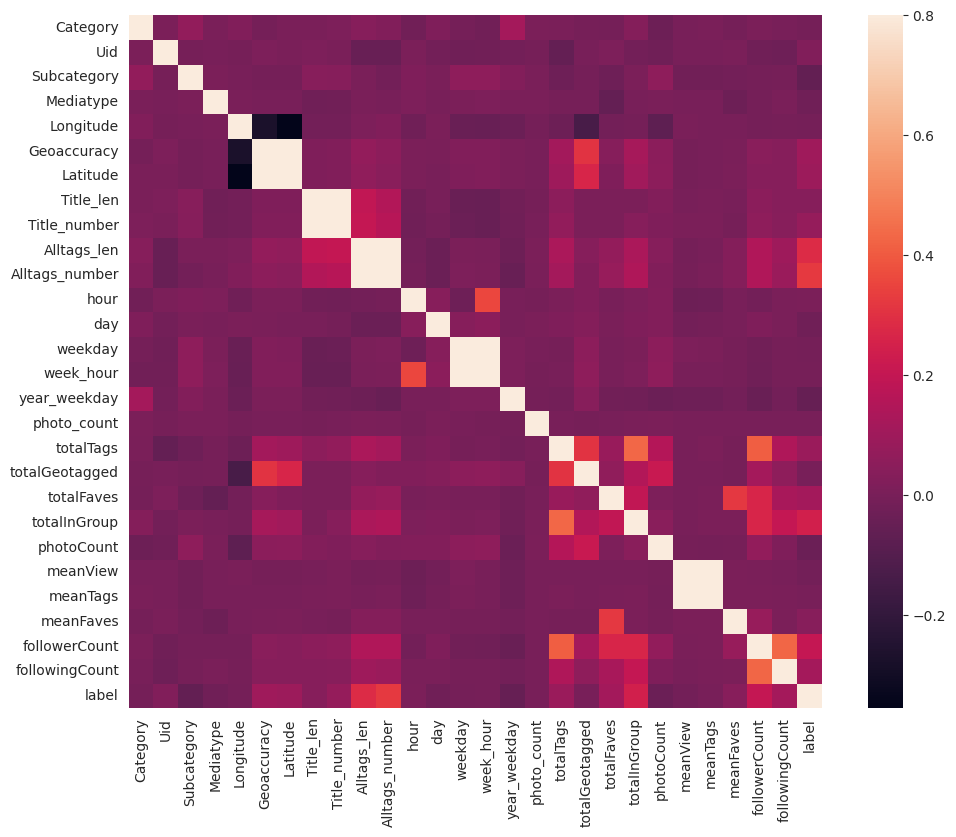

In [46]:
partial_train = train_all_data[columns]
#correlation matrix
corrmat = partial_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

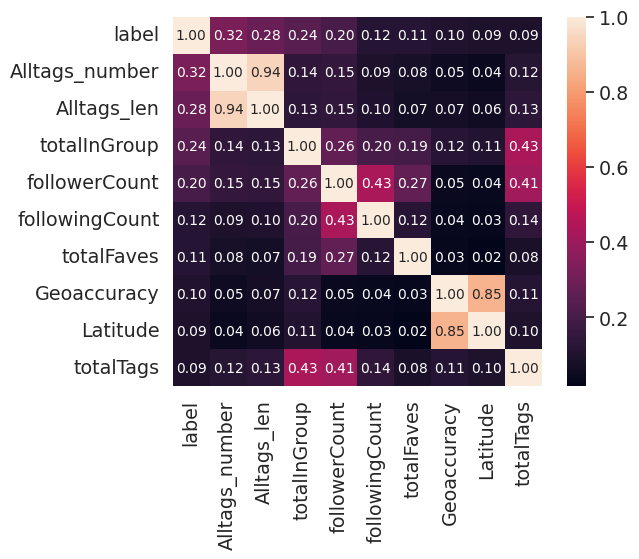

In [49]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(partial_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [51]:
#standardizing data
from sklearn.preprocessing import StandardScaler
saleprice_scaled = StandardScaler().fit_transform(partial_train['label'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]
 [-2.18581315]]

outer range (high) of the distribution:
[[4.06165013]
 [4.06973747]
 [4.07378113]
 [4.07378113]
 [4.08186846]
 [4.08591213]
 [4.08995579]
 [4.10208679]
 [4.10208679]
 [4.10613046]]


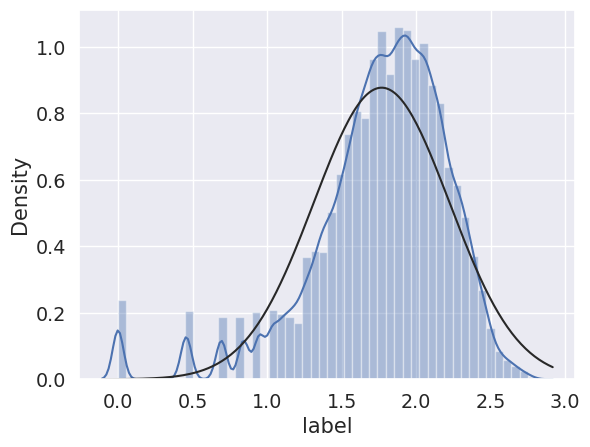

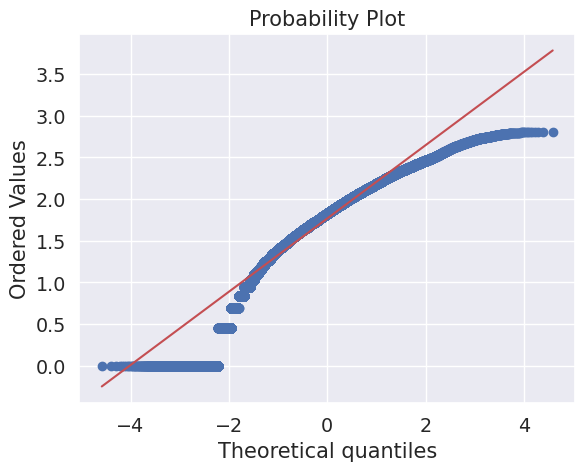

In [52]:
#transformed histogram and normal probability plot
log_popu = np.log(partial_train['label'])
sns.distplot(log_popu, fit=norm);
fig = plt.figure()
res = stats.probplot(log_popu, plot=plt)

In [4]:
# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics2 = []
# for i in features.columns:
#     if features[i].dtype in numeric_dtypes:
#         numerics2.append(i)
columns = ['Category', 'Uid', 'Subcategory','Mediatype', 'Longitude', 'Geoaccuracy', 'Latitude', 
         'Title_len', 'Title_number','Alltags_len','Alltags_number', 'hour', 'day','weekday','week_hour',
          'year_weekday','photo_count', 'totalTags', 'totalGeotagged', 'totalFaves',
          'totalInGroup','photoCount','meanView', 'meanTags', 'meanFaves', 'followerCount',
          'followingCount']


skew_features = all_data[columns].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.75]
skew_index = high_skew.index

for i in skew_index:
    all_data[i] = np.log1p(all_data[i])
    # boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,title_fe_290,title_fe_291,title_fe_292,title_fe_293,title_fe_294,title_fe_295,title_fe_296,title_fe_297,title_fe_298,title_fe_299
0,775,0,21894,4,8.690000,5,65,75,3.526361,1.945910,...,-0.055784,0.197610,-0.166620,-0.007064,0.308736,0.138135,0.149598,0.184107,-0.049617,0.011684
1,1075,0,53866,13,7.525385,0,75,139,4.043051,2.639057,...,0.296695,0.087271,0.126468,-0.103056,0.147320,0.193802,0.035001,-0.045986,0.080715,0.078193
2,4890,0,26948,1,10.990000,3,42,480,2.564949,1.098612,...,0.168270,0.003270,0.171345,0.108478,0.349160,-0.396890,-0.205695,0.068778,-0.128545,-0.080683
3,6568,0,355,1,8.630000,10,68,225,2.944439,1.386294,...,0.109710,0.117009,0.245160,-0.306995,0.387836,0.111045,0.157754,-0.086720,0.220020,-0.045470
4,7079,0,315,31,8.489677,2,43,317,2.197225,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,1118324,-1,46088,2,4.380000,0,35,301,1.945910,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
486190,1118329,-1,12280,7,1.382857,0,60,110,3.258097,1.609438,...,0.134555,0.186670,0.330580,0.227405,0.155600,-0.088244,0.144885,-0.199950,0.033038,-0.065841
486191,1118336,-1,43496,9,3.674444,4,28,186,3.737670,2.079442,...,0.156818,-0.107772,0.157098,-0.079490,0.042594,-0.034590,-0.349488,0.016242,-0.172004,-0.012735
486192,1118349,-1,5492,17,5.671176,7,27,54,2.772589,1.386294,...,0.142362,-0.097873,-0.026855,0.195713,-0.101540,0.240027,-0.119417,-0.012023,0.021850,-0.081305


In [6]:
all_data.to_csv('../data/norm_fea_data_530.csv', header=True)

In [10]:
cate_cols = ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
             'Geoaccuracy', 'ispro' , 'Ispublic']
all_data[cate_cols]

,Uid,Category,Subcategory,Concept,Mediatype,hour,day,weekday,week_hour,year_weekday,Geoaccuracy,ispro,Ispublic
0,21894,5,65,75,1,15,28,2,29,44,0.000000,1,1
1,53866,0,75,139,1,10,9,1,17,6,0.000000,1,1
2,26948,3,42,480,1,8,1,0,8,23,0.000000,0,1
3,355,10,68,225,1,0,1,4,28,53,0.000000,1,1
4,315,2,43,317,1,0,8,6,42,10,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,46088,0,35,301,1,17,10,4,45,23,0.000000,1,1
486190,12280,0,60,110,1,15,10,4,43,23,0.000000,0,1
486191,43496,4,28,186,1,8,8,2,22,23,2.772589,0,1
486192,5492,7,27,54,1,12,10,4,40,23,0.000000,1,1


In [7]:
all_data

,Pid,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,...,title_fe_290,title_fe_291,title_fe_292,title_fe_293,title_fe_294,title_fe_295,title_fe_296,title_fe_297,title_fe_298,title_fe_299
0,775,0,21894,4,8.690000,5,65,75,3.526361,1.945910,...,-0.055784,0.197610,-0.166620,-0.007064,0.308736,0.138135,0.149598,0.184107,-0.049617,0.011684
1,1075,0,53866,13,7.525385,0,75,139,4.043051,2.639057,...,0.296695,0.087271,0.126468,-0.103056,0.147320,0.193802,0.035001,-0.045986,0.080715,0.078193
2,4890,0,26948,1,10.990000,3,42,480,2.564949,1.098612,...,0.168270,0.003270,0.171345,0.108478,0.349160,-0.396890,-0.205695,0.068778,-0.128545,-0.080683
3,6568,0,355,1,8.630000,10,68,225,2.944439,1.386294,...,0.109710,0.117009,0.245160,-0.306995,0.387836,0.111045,0.157754,-0.086720,0.220020,-0.045470
4,7079,0,315,31,8.489677,2,43,317,2.197225,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,1118324,-1,46088,2,4.380000,0,35,301,1.945910,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
486190,1118329,-1,12280,7,1.382857,0,60,110,3.258097,1.609438,...,0.134555,0.186670,0.330580,0.227405,0.155600,-0.088244,0.144885,-0.199950,0.033038,-0.065841
486191,1118336,-1,43496,9,3.674444,4,28,186,3.737670,2.079442,...,0.156818,-0.107772,0.157098,-0.079490,0.042594,-0.034590,-0.349488,0.016242,-0.172004,-0.012735
486192,1118349,-1,5492,17,5.671176,7,27,54,2.772589,1.386294,...,0.142362,-0.097873,-0.026855,0.195713,-0.101540,0.240027,-0.119417,-0.012023,0.021850,-0.081305


In [ ]:
import json
import os
import numpy as np
import pandas as pd
import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
# from sklearn.model_selection import GridSearchCV


# In[ ]:


all_data = pd.read_csv('../data/norm_fea_data_530.csv')
# glove
# glove_tags = pd.read_csv('../data/alltags_feature.csv')
# glove_title = pd.read_csv('../data/title_feature.csv')
# clip_text = pd.read_csv('../data/clip_text_fea_512.csv')
# clip_image = pd.read_csv('../data/clip_image_fea_512.csv')
# vilt_flickr = pd.read_csv('../data/vilt_fea_flickr.csv')
# vilt_vqa = pd.read_csv('../data/vilt_fea_vqa.csv')
# bert_fea = pd.read_csv('../data/bert_fea.csv')
# bertweet_fea = pd.read_csv('../data/bertweet_fea.csv')
# all_data = pd.concat([all_data, glove_tags, glove_title, clip_text, clip_image, vilt_flickr, vilt_vqa, bert_fea, bertweet_fea], axis=1)
# all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)


# In[ ]:


train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]

## norm the training set distribution
# train_all_data['label'] = train_all_data['label'] * 0.8
# train_all_data.loc[train_all_data['label'] ==0.8 ] = 1.0

train_all_data = train_all_data.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'label', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_label_df = train_all_data[['Pid', 'label']]
train_feature_df = train_all_data.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)

print(len(train_feature_df), len(submit_feature_df))
print(len(train_label_df), len(submit_label_df))


# In[ ]:
####################################################################
# cv_params = {"learning_rate":[0.02,0.03,0.04],"depth":[6,8,12]}
# other_params =  {
#     'objective': 'RMSE',
#     'eval_metric': 'MAE',
#     'learning_rate': 0.03,
#     'l2_leaf_reg': 3,
#     'max_ctr_complexity': 1,
#     'depth': 8,
#     'leaf_estimation_method': 'Gradient',
#     'use_best_model': True,
#     'iterations': 100000,
#     'early_stopping_rounds': 5000,
#     'verbose': 500,
#     'task_type':"GPU",
#     'devices':'4:7'
# }
# cate_cols = ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
#              'Geoaccuracy', 'ispro' , 'Ispublic', 'img_model']
# submit_data = Pool(data=submit_feature_df, label=submit_label_df['label'], cat_features=cate_cols)
# model_cb = CatBoostRegressor(**other_params)
# optimized_cb = GridSearchCV(estimator=model_cb, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
# train_data = []
# valid_data = []
# # train_data = Pool(data=train_feature_df, label=train_label_df, cat_features=cate_cols)
# # valid_data = Pool(data=fold_valid_x, label=fold_valid_y, cat_features=cate_cols)
# # optimized_cb.fit(X,y,cat_features =category_features)

# optimized_cb.fit(train_feature_df,train_label_df,cat_features=cate_cols)




# print('参数的最佳取值：{0}'.format(optimized_cb.best_params_))
# print('最佳模型得分:{0}'.format(optimized_cb.best_score_))
# print(optimized_cb.cv_results_['mean_test_score'])
# print(optimized_cb.cv_results_['params'])

#####################################################################

cb_params = {
    'objective': 'RMSE',
    'eval_metric': 'MAE',
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'max_ctr_complexity': 1,
    'depth': 8,
    'leaf_estimation_method': 'Gradient',
    'use_best_model': True,
    'iterations': 200000,
    'early_stopping_rounds': 5000,
    'verbose': 1000,
    'task_type':"GPU",
    'devices':'1,2,3'
}


# cate_cols = ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
#              'Geoaccuracy', 'ispro' , 'Ispublic', 'img_model']
cate_cols = ['Uid', 'Category', 'Subcategory', 'Concept', 'Mediatype', 'hour', 'day', 'weekday', 'week_hour', 'year_weekday',
            'ispro' , 'Ispublic']
submit_data = Pool(data=submit_feature_df, label=submit_label_df['label'], cat_features=cate_cols)


valid_ans = []
submit_proba = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)
k = 0

for train_idx, valid_idx in kfold.split(train_feature_df, train_label_df):
    fold_train_x, fold_train_y = train_feature_df.loc[train_idx], train_label_df['label'].loc[train_idx]
    fold_valid_x, fold_valid_y = train_feature_df.loc[valid_idx], train_label_df['label'].loc[valid_idx]
    
    train_data = Pool(data=fold_train_x, label=fold_train_y, cat_features=cate_cols)
    valid_data = Pool(data=fold_valid_x, label=fold_valid_y, cat_features=cate_cols)
    
    cb_model=CatBoostRegressor(**cb_params)
    cb_model.fit(train_data, eval_set=valid_data)
    
    valid_pred = cb_model.predict(valid_data)
    valid_mse = mean_squared_error(fold_valid_y, valid_pred)
    valid_mae = mean_absolute_error(fold_valid_y, valid_pred)
    valid_src = stats.spearmanr(fold_valid_y, valid_pred)[0]
    
    print("MSE: %.4f, MAE: %.4f, SRC: %.4f"%(valid_mse, valid_mae, valid_src))
    valid_ans.append([valid_mse, valid_mae, valid_src])
        
    submit_pred = cb_model.predict(submit_data)
    submit_proba.append(submit_pred)
    
    cb_model.save_model('../data/save_model/ori_checkpoint/KFold_catboost_' + str(k) + '.pkl')
    k += 1

valid_ans = np.mean(valid_ans, axis=0)
print("valid: MSE: %.4f, MAE: %.4f, SRC: %.4f"%(valid_ans[0], valid_ans[1], valid_ans[2]))

# save result json
submit_ans = np.mean(submit_proba, axis=0)
result = pd.DataFrame()
result['post_id'] = submit_label_df['Pid'].apply(lambda x: 'post' + str(x))
result['popularity_score'] = submit_ans.round(decimals=4)

out_json = dict()
out_json["version"] = "VERSION 3.0"
out_json["result"] = result.to_dict(orient='records')
out_json["external_data"] = {"used": "true", "details": "Norm some metrics"}
f = open('KFold_catboost_norm.json', "w")
json.dump(out_json, f)
f.close()

305613 180581
305613 180581


In [8]:
feature_columns = ['mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

all_data = all_data.drop(feature_columns, axis=1)
all_data

,train_type,Uid,Uid_count,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,Alltags_number,...,title_fe_290,title_fe_291,title_fe_292,title_fe_293,title_fe_294,title_fe_295,title_fe_296,title_fe_297,title_fe_298,title_fe_299
0,0,21894,4,5,65,75,3.526361,1.945910,4.859812,2.564949,...,-0.055784,0.197610,-0.166620,-0.007064,0.308736,0.138135,0.149598,0.184107,-0.049617,0.011684
1,0,53866,13,0,75,139,4.043051,2.639057,6.685861,4.189655,...,0.296695,0.087271,0.126468,-0.103056,0.147320,0.193802,0.035001,-0.045986,0.080715,0.078193
2,0,26948,1,3,42,480,2.564949,1.098612,5.241747,3.178054,...,0.168270,0.003270,0.171345,0.108478,0.349160,-0.396890,-0.205695,0.068778,-0.128545,-0.080683
3,0,355,1,10,68,225,2.944439,1.386294,4.127134,2.302585,...,0.109710,0.117009,0.245160,-0.306995,0.387836,0.111045,0.157754,-0.086720,0.220020,-0.045470
4,0,315,31,2,43,317,2.197225,0.693147,4.990433,2.995732,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,-1,46088,2,0,35,301,1.945910,0.693147,4.369448,2.639057,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
486190,-1,12280,7,0,60,110,3.258097,1.609438,5.105945,3.178054,...,0.134555,0.186670,0.330580,0.227405,0.155600,-0.088244,0.144885,-0.199950,0.033038,-0.065841
486191,-1,43496,9,4,28,186,3.737670,2.079442,4.454347,2.302585,...,0.156818,-0.107772,0.157098,-0.079490,0.042594,-0.034590,-0.349488,0.016242,-0.172004,-0.012735
486192,-1,5492,17,7,27,54,2.772589,1.386294,5.723585,3.583519,...,0.142362,-0.097873,-0.026855,0.195713,-0.101540,0.240027,-0.119417,-0.012023,0.021850,-0.081305


In [9]:
all_data.to_csv('../data/norm_fea_data_530.csv', header=True)

KeyboardInterrupt: 

In [62]:
all_data.columns

Index(['train_type', 'Uid', 'Uid_count', 'Category', 'Subcategory', 'Concept',
       'Title_len', 'Title_number', 'Alltags_len', 'Alltags_number',
       ...
       'title_fe_290', 'title_fe_291', 'title_fe_292', 'title_fe_293',
       'title_fe_294', 'title_fe_295', 'title_fe_296', 'title_fe_297',
       'title_fe_298', 'title_fe_299'],
      dtype='object', length=684)

In [61]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = all_data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_data[i] = np.log1p(all_data[i])
#     boxcox1p(features[i], boxcox_normmax(features[i] + 1))
# skewed = skewed[skewed > 0.75]
# skewed = skewed.index

# train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
# test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

In [ ]:
all_data

In [59]:
# .skew
#skewness and kurtosis
print("Skewness of Uid: %f" % all_data['Uid'].skew())
print("Kurtosis of Uid: %f" % all_data['Uid'].kurt())

Skewness of Uid: 0.040190
Kurtosis of Uid: -1.181807


In [ ]:
all_data = pd.concat([all_data, glove_tags, glove_title], axis=1)
train_all_data = all_data[all_data['train_type'] != -1]
submit_all_data = all_data[all_data['train_type'] == -1]


 mu = 1.94 and sigma = 0.37



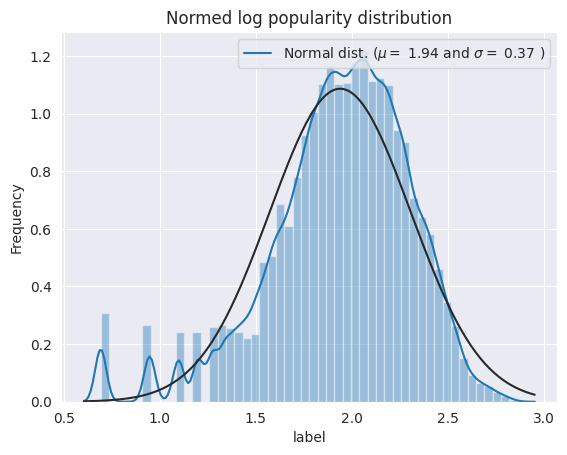

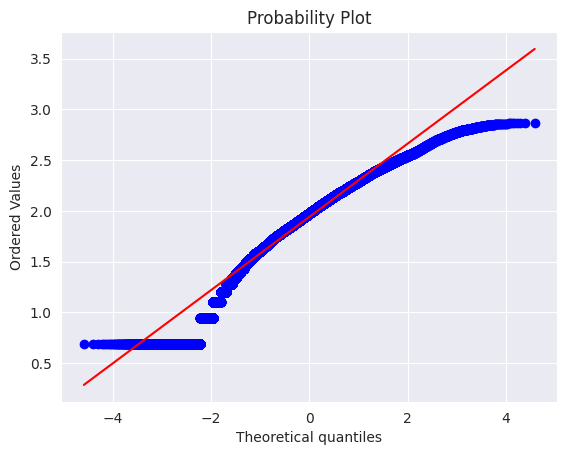

In [16]:
# # Log-transformation of the target variable
# #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# train_all_data['label'] = np.log1p(train_all_data['label'])

# #Check the new distribution 
# sns.distplot(train_all_data['label'] , fit=norm);

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train_all_data['label'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('Normed log popularity distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train_all_data['label'], plot=plt)
# plt.show()

In [48]:
all_data

,alltags_fe_0,alltags_fe_1,alltags_fe_2,alltags_fe_3,alltags_fe_4,alltags_fe_5,alltags_fe_6,alltags_fe_7,alltags_fe_8,alltags_fe_9,...,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label
0,0.105465,-0.040479,-0.194198,0.128030,0.313682,-0.061265,-0.992011,-0.312834,-0.013565,-0.040851,...,904,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18
1,0.093095,0.023672,0.290516,-0.090829,0.124235,-0.187277,-1.244145,-0.066525,0.042617,-0.229900,...,6200,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15
2,-0.255355,0.000503,-0.149442,0.213503,0.006936,0.189376,-1.667589,-0.125766,0.068157,-0.236353,...,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99
3,0.024219,0.011845,-0.311390,0.261167,0.148537,0.079416,-1.426959,-0.147087,-0.248824,-0.127153,...,76088,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63
4,-0.208299,-0.048151,-0.068100,-0.099640,-0.071001,0.278434,-1.477279,-0.100605,0.175074,-0.420982,...,0,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,-0.110066,-0.082020,-0.106421,-0.177982,0.064599,0.141631,-1.355130,-0.131778,0.010077,-0.169654,...,4341,84,347,833.933718,2.844380,12.510086,489,612,1,0.00
486190,0.010292,-0.079230,0.068187,0.139529,-0.005079,0.068774,-1.309018,-0.268348,-0.185020,-0.069245,...,0,0,0,0.000000,0.000000,0.000000,0,0,1,0.00
486191,0.175281,0.256163,-0.188274,0.334853,0.177587,-0.103842,-0.845013,-0.158594,0.042176,0.007087,...,5225,98,6556,1611.040268,3.334503,0.796980,702,113,1,0.00
486192,0.075871,-0.115838,-0.032150,0.056449,0.026431,-0.111147,-1.371155,0.146692,0.071802,0.007916,...,24679,373,2138,2480.537418,2.655285,11.543031,1092,389,1,0.00


In [49]:
train_all_data = all_data[all_data['train_type'] != -1]

index = list(range(len(train_all_data)))
length = len(train_all_data)
len_valid = int(length * 0.15 + 0.6)
train_data_df = train_all_data.loc[index[:-len_valid]]
valid_data_df = train_all_data.loc[index[-len_valid:]]
submit_all_data = all_data[all_data['train_type'] == -1]

train_data_df = train_data_df.reset_index(drop=True)
valid_data_df = valid_data_df.reset_index(drop=True)
submit_all_data = submit_all_data.reset_index(drop=True)

feature_columns = ['Pid', 'train_type', 'mean_label'] 
feature_columns += ['user_fe_{}'.format(i) for i in range(399)]
feature_columns += ['loc_fe_{}'.format(i) for i in range(400)]

train_feature_df = train_data_df.drop(feature_columns, axis=1)
valid_feature_df = valid_data_df.drop(feature_columns, axis=1)

submit_label_df = submit_all_data[['Pid', 'label']]
submit_feature_df = submit_all_data.drop(feature_columns, axis=1)
tfdf = train_feature_df.to_numpy(dtype='float')
vfdf = valid_feature_df.to_numpy(dtype='float')
sfdf = submit_feature_df.to_numpy(dtype='float')
numpy.savetxt("../data/SMP.data.train", tfdf)
numpy.savetxt("../data/SMP.data.val", vfdf)
numpy.savetxt("../data/SMP.data.test", sfdf)

In [26]:
nptf = train_feature_df.to_numpy(dtype='float')

In [31]:
len(nptf[0])

682

In [37]:
train_all_data['train_type'].unique()

array([0, 1, 2])

In [6]:
df_train_label = list(pd.read_csv('../data/train_all_json/train_label.txt', header=None)[0])
# df_train_label

In [2]:
all_data = pd.read_csv('../data/feature_data_vilt_flick.csv', low_memory=False, index_col=0)
all_data = all_data.fillna('0')
data_df = all_data
data_df

,train_type,Uid,Uid_count,mean_label,Category,Subcategory,Concept,Title_len,Title_number,Alltags_len,...,totalFaves,totalInGroup,photoCount,meanView,meanTags,meanFaves,followerCount,followingCount,Ispublic,label
Pid,,,,,,,,,,,,,,,,,,,,,
775,0,50349,4,8.690000,3,42,659,33,6,128,...,904,176,1446,4299.470263,1.531812,0.625173,2405,2729,1,11.18
1075,0,29486,13,7.525385,6,69,259,56,13,800,...,6200,679,75883,735.884072,0.052594,0.081705,8491,236,1,15.15
4890,0,42303,1,10.990000,9,44,17,12,2,188,...,2583,2,1039,5124.185756,2.820019,2.486044,1550,1346,1,10.99
6568,0,51015,1,8.630000,5,0,416,18,3,61,...,76088,385,124017,148.035342,0.046018,0.613529,1233,1115,1,8.63
7079,0,18345,31,8.489677,1,26,6,8,1,146,...,0,102,9218,5300.882729,0.579735,0.000000,5781,13,1,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118324,-1,38530,2,4.380000,6,73,649,6,1,78,...,4341,84,347,833.933718,2.844380,12.510086,489,612,1,0.00
1118329,-1,52233,7,1.382857,6,45,194,25,4,164,...,0,0,0,0.000000,0.000000,0.000000,0,0,1,0.00
1118336,-1,7951,9,3.674444,2,61,508,41,7,85,...,5225,98,6556,1611.040268,3.334503,0.796980,702,113,1,0.00


In [2]:
train_tags = json.load(open('../data/train_all_json/train_text.json', encoding="utf-8"))
train_tags_pd = pd.DataFrame(train_tags)
train_tags_pd

,Alltags,Pid,Uid,Mediatype,Title
0,rock punk transgender tranny electronicmusic e...,775,59@N75,photo,Luis Drayton - Edinburgh shoot #6
1,brazil rio brasil riodejaneiro by maria fifa m...,1075,1@N18,photo,Arena da Barra - Arena HSBC - Arena do PAN #...
2,old cinema beauty marilyn photoshop movie joke...,4890,351@N64,photo,MARILYN 2015
3,pictures old family scans brothers sister 1958...,6568,6@N59,photo,Knikkertijd - 1959
4,hot sahara animal animals desert bottles drink...,7079,1617@N40,photo,CAMELS01
...,...,...,...,...,...
305608,york travel sky urban sun france color tree gr...,1118328,62225@N20,photo,Mushrooms
305609,portrait cute animal cat furry panasonic calic...,1118334,108435@N35,photo,Evie
305610,car exotic german malaysia kualalumpur superca...,1118342,84730@N71,photo,BSSLS+R8GT!!
305611,city newzealand christchurch cloud building ca...,1118344,9542@N37,photo,C to A1


In [ ]:
## 训练集共有305613个图片,有305613个sample;
## 测试集共有180581个图片，有180581个sample;
## 共有486194个图片和sample